In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

print("Initalized")

Initalized


Table of Content
- [First Look](#First-Look)
- [Redo](#Redo)
- [Bonus](#Bonus)

# First Look

In [2]:
# Read the data
data = pd.read_csv('anonymized-curriculum-access.txt', sep=" ", header=None, na_values='"-"')
# From the https://ds.codeup.com/anomaly-detection/time-series-anomaly-detection-part-3/ rename columns as needed
data.columns=['date', 'time', 'page_viewed','user_id','cohort_id','ip']
# Combine the date time columns and set to datetime object
data['datetime'] = data['date'] + ' ' + data['time']
data['datetime'] = pd.to_datetime(data.datetime)
#Set the index to the new datetime column and sort it
data = data.set_index('datetime')
data['hour'] = data.index.hour
data.head()

,date,time,page_viewed,user_id,cohort_id,ip,hour
datetime,,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,9
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,9
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,9
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,9
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,9


In [3]:
# Create an entropy function
def compute_entropy(series):
    counts = series.value_counts()
    if len(counts)==1:
        ent = 0
    else:
        value, counts = np.unique(series, return_counts=True)
        ent = entropy(counts, base=None)
    return ent

compute_entropy(data['cohort_id'])

3.9027926786187983

In [4]:
# Look at the total null values
data.ip.count()

719459

In [5]:
#create a data frame that gets the number of hits per hour date, the probaility of that, and the probaility of having a hit at a certain hour
hour_hits = pd.DataFrame(data['ip'].resample('H').count())
hour_hits.columns=['hits']
hour_hits['hits_proba'] = hour_hits['hits']/data.ip.count()
hour_hits['hour'] = hour_hits.index.hour
temp = hour_hits[['hits', 'hour']].groupby('hour').sum()
temp.reset_index(inplace=True)
temp.columns=['hour', 'hits_by_hour_total']
hour_hits = hour_hits.reset_index().merge(temp, how="left", on='hour').set_index('datetime')
hour_hits['hits_by_hour_proba'] = hour_hits['hits']/hour_hits['hits_by_hour_total']
hour_hits = hour_hits[['hits', 'hour', 'hits_proba', 'hits_by_hour_proba']]
hour_hits

,hits,hour,hits_proba,hits_by_hour_proba
datetime,,,,
2018-01-26 09:00:00,11,9,0.000015,0.000107
2018-01-26 10:00:00,63,10,0.000088,0.000883
2018-01-26 11:00:00,101,11,0.000140,0.001368
2018-01-26 12:00:00,28,12,0.000039,0.000707
2018-01-26 13:00:00,54,13,0.000075,0.000883
...,...,...,...,...
2020-11-02 12:00:00,106,12,0.000147,0.002677
2020-11-02 13:00:00,531,13,0.000738,0.008683
2020-11-02 14:00:00,217,14,0.000302,0.002994


In [6]:
data.resample('H')['ip'].value_counts()

datetime             ip             
2018-01-26 09:00:00  97.105.19.61        11
2018-01-26 10:00:00  97.105.19.61        61
                     71.137.146.71        2
2018-01-26 11:00:00  97.105.19.61       101
2018-01-26 12:00:00  97.105.19.61        22
                                       ... 
2020-11-02 16:00:00  173.172.202.149      1
                     70.121.134.234       1
                     70.121.201.159       1
                     70.94.150.75         1
                     99.43.143.116        1
Name: ip, Length: 97835, dtype: int64

In [7]:
# Make a df of the total views per page
page_views = pd.DataFrame(data['page_viewed'].value_counts()).reset_index()
page_views.columns=['page', 'total_page_views']

# Merge the page views on the original data frame
data = data.merge(page_views, how='left', left_on='page_viewed', right_on='page')
# Drop the page_viewed columns
data.drop(columns=['page_viewed'])
data

,date,time,page_viewed,user_id,cohort_id,ip,hour,page,total_page_views
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,9,/,40122.0
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,9,java-ii,10374.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,9,java-ii/object-oriented-programming,5241.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,9,slides/object_oriented_programming,487.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,9,javascript-i/conditionals,5184.0
...,...,...,...,...,...,...,...,...,...
719454,2020-11-02,16:48:13,javascript-i/coffee-project,763,62.0,107.192.148.199,16,javascript-i/coffee-project,2895.0
719455,2020-11-02,16:48:17,javascript-i/mapbox-api,771,62.0,172.125.226.175,16,javascript-i/mapbox-api,2567.0
719456,2020-11-02,16:48:18,javascript-i/coffee-project,771,62.0,172.125.226.175,16,javascript-i/coffee-project,2895.0
719457,2020-11-02,16:48:28,javascript-i/bom-and-dom/bom,771,62.0,172.125.226.175,16,javascript-i/bom-and-dom/bom,3516.0


In [8]:
# Create a dataframe that is grouped by user_id and cohort_id that that counts the number of times each page was viewed by the pair
user_viewed = pd.DataFrame(data[['user_id', 'cohort_id', 'page_viewed']].groupby(['user_id', 'cohort_id'])['page_viewed'].value_counts())
user_viewed.columns=['times_viewed']
user_viewed.reset_index(inplace=True)

#create a dataframe that gets the number of times a page was viewed total per cohort
total_viewed = user_viewed[['cohort_id', 'page_viewed', 'times_viewed']].groupby(['cohort_id', 'page_viewed']).sum().reset_index()
total_viewed.columns=['cohort_id', 'page_viewed', 'total_cohort_views']
user_viewed = user_viewed.merge(total_viewed, on=['cohort_id', 'page_viewed'], how='left') 
# Create the percent viewed 
user_viewed['percent_viewed'] = user_viewed['times_viewed']/user_viewed['total_cohort_views']
user_viewed.sort_values(by=['cohort_id','user_id'])

,user_id,cohort_id,page_viewed,times_viewed,total_cohort_views,percent_viewed
2458,11,1.0,/,237,622,0.381029
2459,11,1.0,javascript-i,150,294,0.510204
2460,11,1.0,html-css,104,215,0.483721
2461,11,1.0,java-ii,85,167,0.508982
2462,11,1.0,javascript-ii,84,204,0.411765
...,...,...,...,...,...,...
89119,776,62.0,mysql/intellij,1,2,0.500000
89120,776,62.0,mysql/sample-database,1,1,1.000000
89121,776,62.0,search/search_index.json,1,121,0.008264
89122,776,62.0,slides/introduction_to_java,1,1,1.000000


In [9]:
# Create a data frame with that groups by user_id, cohort_id that counts the number of total visits for the pair
hits = user_viewed[['user_id','cohort_id']].groupby(['user_id','cohort_id']).size().reset_index()
hits.columns=['user_id', 'cohort_id', 'hits']
# Create a dataframe that sums up the number of hits per cohort
total_hits = hits[['hits','cohort_id']].groupby('cohort_id').sum().reset_index()
total_hits.columns=['cohort_id', 'total_hits_for_cohort']
#merge the two data frames
hits = hits.merge(total_hits, on='cohort_id', how='left')
hits

,user_id,cohort_id,hits,total_hits_for_cohort
0,1,8.0,248,309
1,1,28.0,774,5576
2,2,22.0,151,4811
3,3,22.0,169,4811
4,4,22.0,143,4811
...,...,...,...,...
743,783,59.0,13,3314
744,784,61.0,33,2416
745,785,59.0,14,3314
746,786,56.0,6,3178


# Redo
Needed a fresh look at the data and attemp to gain insights

In [10]:
# Read the data
data = pd.read_csv('anonymized-curriculum-access.txt', sep=" ", header=None, na_values='"-"')
# From the https://ds.codeup.com/anomaly-detection/time-series-anomaly-detection-part-3/ rename columns as needed
data.columns=['date', 'time', 'page_viewed','user_id','cohort_id','ip']
# Combine the date time columns and set to datetime object
data['datetime'] = data['date'] + ' ' + data['time']
data['datetime'] = pd.to_datetime(data.datetime)
#Set the index to the new datetime column and sort it
data = data.set_index('datetime')
# Create columns for hour, day of week, and month
data['hour'] = data.index.hour
data['day'] = data.index.day_name()
data['month'] = data.index.month
# Print the head
data.head()

,date,time,page_viewed,user_id,cohort_id,ip,hour,day,month
datetime,,,,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,9,Friday,1
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,9,Friday,1
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,9,Friday,1
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,9,Friday,1
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,9,Friday,1


In [11]:
# Check for percentage of null values
data.isnull().mean()

date           0.000000
time           0.000000
page_viewed    0.000001
user_id        0.000000
cohort_id      0.062325
ip             0.000000
hour           0.000000
day            0.000000
month          0.000000
dtype: float64

In [12]:
# Create a data frame to see the probaility for hits by hour of the day
hour_probaility = pd.DataFrame(data['hour'].value_counts()/data.shape[0]).reset_index()
hour_probaility.columns=['hour', 'probaility']
hour_probaility.sort_values(by='hour')
#store values with a probaility under 1.5% in a list
hours = hour_probaility[hour_probaility['probaility'] < .015]['hour']

In [13]:
# Probaility of hits happening during the hours listed
data[data.hour.isin(hours)].shape[0]/data.shape[0]

0.048629595293129976

In [14]:
# Create a data frame to see the probaility for page viws 
page_prob = pd.DataFrame(data['page_viewed'].value_counts()/data.shape[0]).reset_index()
page_prob.columns=['page', 'probaility']
page_prob.sort_values(by='probaility',ascending=True)
#store values with a probaility under .00001 in a list
pages = page_prob[page_prob['probaility'] < .00001]['page']
pages

1236            content/javascript/arrays/split-join.html
1237                                 mysql/databases.html
1238                    7-classification/confusion-matrix
1239                          10.04.04_TextClassification
1240                             9-timeseries/5.2-prophet
                              ...                        
2148    appendix/further-reading/css-grid-additional-f...
2149                                          6.04.05_SVM
2150                                          team-setups
2151                                               data-1
2152        content/appendix/postwork/facebook-clone.html
Name: page, Length: 917, dtype: object

In [15]:
# Probaility of hits happening during the hours listed
possible = data[(data.page_viewed.isin(pages)) & (data.hour.isin(hours))]
possible

,date,time,page_viewed,user_id,cohort_id,ip,hour,day,month
datetime,,,,,,,,,
2018-01-27 06:55:41,2018-01-27,06:55:41,git/branching,38,21.0,173.174.155.172,6,Saturday,1
2018-01-27 07:49:25,2018-01-27,07:49:25,teams/13,1,8.0,72.177.226.58,7,Saturday,1
2018-01-29 00:05:14,2018-01-29,00:05:14,jquery/resume-portfolio,54,NaN,24.160.159.122,0,Monday,1
2018-02-02 23:53:08,2018-02-02,23:53:08,content/appendix/angular/templating.html,51,13.0,72.179.161.39,23,Friday,2
2018-02-02 23:55:39,2018-02-02,23:55:39,content/appendix/angular/models.html,51,13.0,72.179.161.39,23,Friday,2
...,...,...,...,...,...,...,...,...,...
2020-11-01 03:01:30,2020-11-01,03:01:30,advanced-topics/intro-to-flask,730,61.0,68.203.188.247,3,Sunday,11
2020-11-01 03:02:00,2020-11-01,03:02:00,advanced-topics/html-templates,730,61.0,68.203.188.247,3,Sunday,11
2020-11-01 03:02:30,2020-11-01,03:02:30,advanced-topics/html-forms,730,61.0,68.203.188.247,3,Sunday,11


Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

In [16]:
data.shape[0]

719459

In [17]:
# Create a dataframe that groups by user_id and cohort_id and then resamples by D to get the number of hits by user + cohort perday
test = pd.DataFrame(data.groupby(['user_id', 'cohort_id']).resample('D').size())
# Reset the index and then set the index to datetime
test = test.reset_index().set_index('datetime')
# Rename the columns as needed
test.columns=['user_id', 'cohort_id', 'hits']
# Print
test

,user_id,cohort_id,hits
datetime,,,
2018-01-26,1,8.0,7
2018-01-27,1,8.0,1
2018-01-28,1,8.0,0
2018-01-29,1,8.0,6
2018-01-30,1,8.0,5
...,...,...,...
2020-10-31,785,59.0,0
2020-11-01,785,59.0,0
2020-11-02,785,59.0,9


In [18]:
short_rolling = pd.DataFrame(test[['user_id', 'cohort_id', 'hits']].groupby(['user_id', 'cohort_id'])['hits'].rolling(window=7).mean())
long_rolling = pd.DataFrame(test[['user_id', 'cohort_id', 'hits']].groupby(['user_id', 'cohort_id'])['hits'].rolling(window=30).mean())
short_rolling = short_rolling.reset_index().set_index('datetime')
long_rolling = long_rolling.reset_index().set_index('datetime')
long_rolling.columns=['user_id', 'cohort_id', '30dayroll']
short_rolling.columns=['user_id', 'cohort_id', '7dayroll']


test = test.merge(short_rolling, on=['user_id', 'cohort_id', 'datetime'], how='inner')
test = test.merge(long_rolling, on=['user_id', 'cohort_id', 'datetime'], how='inner')
test

,user_id,cohort_id,hits,7dayroll,30dayroll
datetime,,,,,
2018-01-26,1,8.0,7,NaN,NaN
2018-01-27,1,8.0,1,NaN,NaN
2018-01-28,1,8.0,0,NaN,NaN
2018-01-29,1,8.0,6,NaN,NaN
2018-01-30,1,8.0,5,NaN,NaN
...,...,...,...,...,...
2020-10-31,785,59.0,0,NaN,NaN
2020-11-01,785,59.0,0,3.142857,NaN
2020-11-02,785,59.0,9,4.285714,NaN


<AxesSubplot:xlabel='datetime,cohort_id,user_id'>

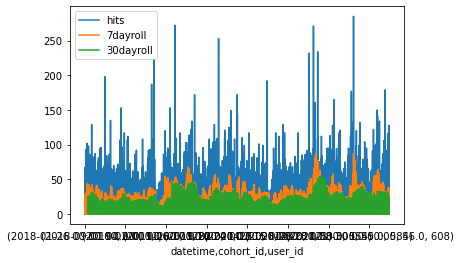

In [19]:
test.groupby(['datetime', 'cohort_id', 'user_id']).mean().plot()

In [21]:
cohort59 = test[test['cohort_id'] == 59.0]
cohort59 = cohort59['hits']
cohort59 = cohort59.resample('D').size()

In [24]:
ema_short = cohort59.ewm(span=7, adjust=False).mean()
ema_long = cohort59.ewm(span=14, adjust=False).mean()
short_rolling = cohort59.rolling(window=7).mean()
long_rolling = cohort59.rolling(window=14).mean()

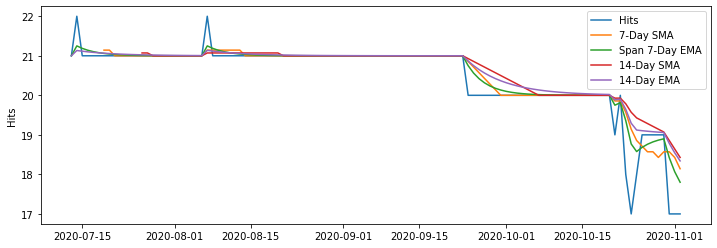

In [25]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(cohort59.index, 
        cohort59,
        label='Hits')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '7-Day SMA')
ax.plot(short_rolling.index, 
        ema_short, 
        label = 'Span 7-Day EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '14-Day SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = '14-Day EMA')

ax.legend(loc='best')
ax.set_ylabel('Hits')
plt.show()

In [28]:
# Create boolinger bands using std * 3 method
stdev = cohort59.ewm(span=14).std()
# Create boolinger bands using std * 3 method
midband = cohort59.ewm(span=14).mean()
ub = midband + stdev*3
lb = midband - stdev*3
midband

datetime
2020-07-13    21.000000
2020-07-14    21.535714
2020-07-15    21.331070
2020-07-16    21.229786
2020-07-17    21.169835
                ...    
2020-10-29    19.068497
2020-10-30    19.059364
2020-10-31    18.784782
2020-11-01    18.546811
2020-11-02    18.340570
Freq: D, Name: hits, Length: 113, dtype: float64

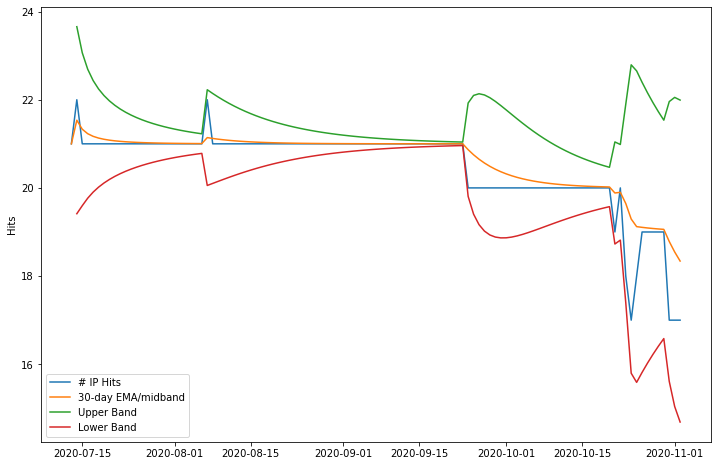

In [29]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(cohort59.index, 
        cohort59,
        label='# IP Hits')

ax.plot(cohort59.index, 
        midband, 
        label = '30-day EMA/midband')
ax.plot(cohort59.index, 
        ub, 
        label = 'Upper Band')
ax.plot(cohort59.index, 
        lb, 
        label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Hits')
plt.show()

In [31]:
cohort59 = pd.concat([cohort59, midband, ub, lb], axis=1)
cohort59.columns = ['ip_hits', 'midband', 'ub', 'lb']
cohort59.tail()

,ip_hits,midband,ub,lb
datetime,,,,
2020-10-29,19,19.068497,21.728439,16.408555
2020-10-30,19,19.059364,21.536696,16.582032
2020-10-31,17,18.784782,21.957916,15.611648
2020-11-01,17,18.546811,22.053088,15.040534
2020-11-02,17,18.340570,21.992216,14.688923


In [36]:
# Creating a percent b column
cohort59['pct_b'] = (cohort59['ip_hits'] - cohort59['lb'])/(cohort59['ub'] - cohort59['lb'])
# Sorting by values > 1
cohort59[cohort59['pct_b']>.75]

,ip_hits,midband,ub,lb,pct_b
datetime,,,,,
2020-08-07,22,21.141049,22.226757,20.055341,0.895572


In [37]:
# Test for hits per day
hitsperday = data.resample('D').size()
hitsperday

datetime
2018-01-26     572
2018-01-27     230
2018-01-28     170
2018-01-29     830
2018-01-30     652
              ... 
2020-10-29    1358
2020-10-30     912
2020-10-31     211
2020-11-01     375
2020-11-02    1717
Freq: D, Length: 1012, dtype: int64

In [38]:
ema_short = hitsperday.ewm(span=7, adjust=False).mean()
ema_long = hitsperday.ewm(span=14, adjust=False).mean()
short_rolling = hitsperday.rolling(window=7).mean()
long_rolling = hitsperday.rolling(window=14).mean()

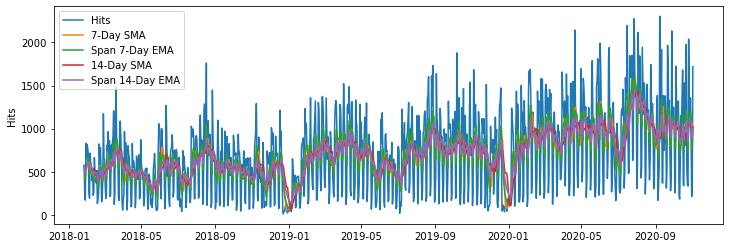

In [39]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(hitsperday.index, 
        hitsperday,
        label='Hits')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '7-Day SMA')
ax.plot(long_rolling.index, 
        ema_short, 
        label = 'Span 7-Day EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '14-Day SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = 'Span 14-Day EMA')

ax.legend(loc='best')
ax.set_ylabel('Hits')
plt.show()

In [42]:
stdev = hitsperday.ewm(span=14).std()
# Create boolinger bands using std * 3 method
midband = hitsperday.ewm(span=14).mean()
ub = midband + stdev*3
lb = midband - stdev*3
midband


datetime
2018-01-26     572.000000
2018-01-27     388.785714
2018-01-28     305.208829
2018-01-29     465.757252
2018-01-30     514.347700
                 ...     
2020-10-29    1107.678796
2020-10-30    1081.588290
2020-10-31     965.509851
2020-11-01     886.775204
2020-11-02     997.471844
Freq: D, Length: 1012, dtype: float64

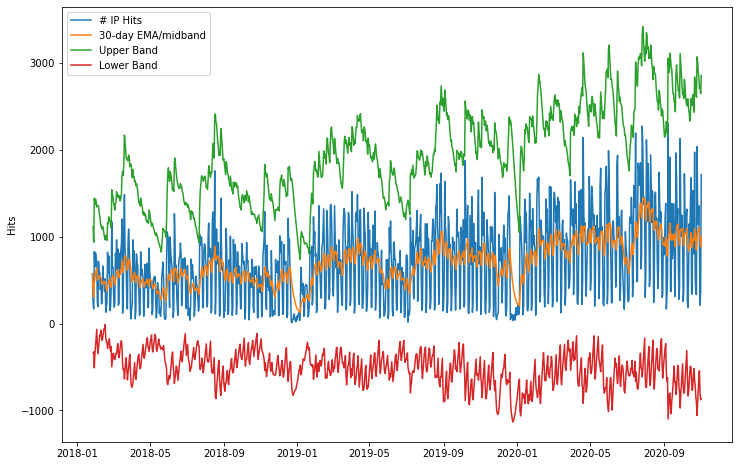

In [44]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(hitsperday.index, 
        hitsperday,
        label='# IP Hits')

ax.plot(hitsperday.index, 
        midband, 
        label = '30-day EMA/midband')
ax.plot(hitsperday.index, 
        ub, 
        label = 'Upper Band')
ax.plot(hitsperday.index, 
        lb, 
        label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Hits')
plt.show()

In [45]:
hitsperday = pd.concat([hitsperday, midband, ub, lb], axis=1)
hitsperday.columns = ['ip_hits', 'midband', 'ub', 'lb']
hitsperday.tail()

,ip_hits,midband,ub,lb
datetime,,,,
2020-10-29,1358,1107.678796,2839.600155,-624.242564
2020-10-30,912,1081.588290,2707.164002,-543.987423
2020-10-31,211,965.509851,2737.243011,-806.223309
2020-11-01,375,886.775204,2650.590968,-877.040560
2020-11-02,1717,997.471844,2859.789192,-864.845505


In [48]:
# Creating a percent b column
hitsperday['pct_b'] = (hitsperday['ip_hits'] - hitsperday['lb'])/(hitsperday['ub'] - hitsperday['lb'])
# Sorting by values > 1
hitsperday[hitsperday['pct_b']>.8]

,ip_hits,midband,ub,lb,pct_b
datetime,,,,,
2018-02-27,1171,521.946861,1542.385058,-498.491336,0.818027
2018-07-23,1027,429.529372,1345.823461,-486.764718,0.826026
2019-01-22,782,332.561321,1076.090429,-410.967787,0.802233
2019-07-08,1225,462.017831,1722.908565,-798.872904,0.802557
2019-10-07,1879,838.297177,2564.044031,-887.449676,0.801522
2020-01-06,1237,341.889153,1687.913817,-1004.135510,0.832502
2020-03-30,1657,832.202848,2202.404252,-537.998556,0.800977
2020-09-08,2304,978.487636,3056.905368,-1099.930095,0.818875


In [49]:
# Dead time by Day
deadtimes = data[data['hour'].isin(hours)]
deadtimes = deadtimes.resample('D').size()
deadtimes

datetime
2018-01-26      7
2018-01-27     60
2018-01-28      7
2018-01-29     49
2018-01-30     15
             ... 
2020-10-29     49
2020-10-30     36
2020-10-31     13
2020-11-01    155
2020-11-02     58
Freq: D, Length: 1012, dtype: int64

In [50]:
ema_short = deadtimes.ewm(span=7, adjust=False).mean()
ema_long = deadtimes.ewm(span=14, adjust=False).mean()
short_rolling = deadtimes.rolling(window=7).mean()
long_rolling = deadtimes.rolling(window=14).mean()

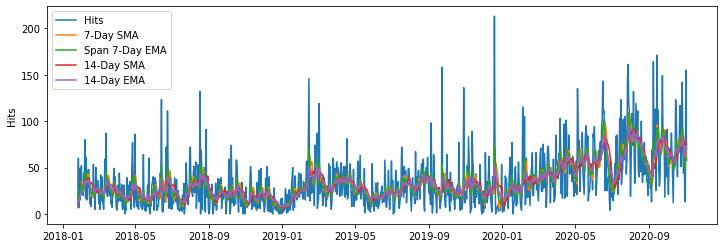

In [51]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(deadtimes.index, 
        deadtimes,
        label='Hits')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '7-Day SMA')
ax.plot(short_rolling.index, 
        ema_short, 
        label = 'Span 7-Day EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '14-Day SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = '14-Day EMA')

ax.legend(loc='best')
ax.set_ylabel('Hits')
plt.show()

In [52]:
stdev = deadtimes.ewm(span=14).std()
# Create boolinger bands using std * 3 method
midband = deadtimes.ewm(span=14).mean()
ub = midband + stdev*3
lb = midband - stdev*3
midband

datetime
2018-01-26     7.000000
2018-01-27    35.392857
2018-01-28    24.546689
2018-01-29    32.027647
2018-01-30    27.585160
                ...    
2020-10-29    72.664016
2020-10-30    67.775481
2020-10-31    60.472083
2020-11-01    73.075805
2020-11-02    71.065698
Freq: D, Length: 1012, dtype: float64

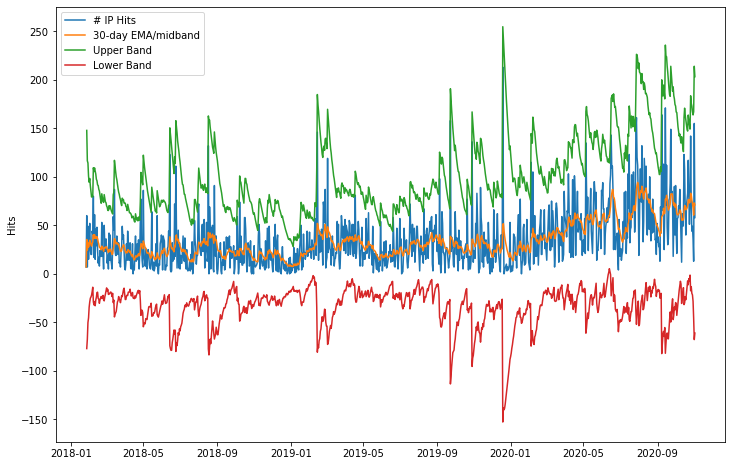

In [53]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(deadtimes.index, 
        deadtimes,
        label='# IP Hits')

ax.plot(deadtimes.index, 
        midband, 
        label = '30-day EMA/midband')
ax.plot(deadtimes.index, 
        ub, 
        label = 'Upper Band')
ax.plot(deadtimes.index, 
        lb, 
        label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Hits')
plt.show()

In [54]:
deadtimes = pd.concat([deadtimes, midband, ub, lb], axis=1)
deadtimes.columns = ['ip_hits', 'midband', 'ub', 'lb']
deadtimes.tail()

,ip_hits,midband,ub,lb
datetime,,,,
2020-10-29,49,72.664016,166.984701,-21.656669
2020-10-30,36,67.775481,163.774262,-28.223301
2020-10-31,13,60.472083,166.996226,-46.052059
2020-11-01,155,73.075805,213.938141,-67.786530
2020-11-02,58,71.065698,203.168403,-61.037007


In [57]:
# Creating a percent b column
deadtimes['pct_b'] = (deadtimes['ip_hits'] - deadtimes['lb'])/(deadtimes['ub'] - deadtimes['lb'])
# Sorting by values > 1
deadtimes[deadtimes['pct_b']>.8]

,ip_hits,midband,ub,lb,pct_b
datetime,,,,,
2018-03-14,87,36.281241,116.964783,-44.402301,0.814307
2018-04-26,55,23.761137,74.733514,-27.211240,0.806429
2018-04-27,77,30.859665,104.522857,-42.803527,0.813184
2018-05-15,64,22.811754,89.319198,-43.695690,0.809651
2018-06-14,123,38.144669,150.440958,-74.151620,0.877819
2018-06-24,111,38.900168,157.818548,-80.018213,0.803148
2018-07-25,55,19.709534,76.547392,-37.128323,0.810449
2018-07-31,67,26.574404,90.306649,-37.157841,0.817152
2018-08-17,132,42.651576,162.721828,-77.418676,0.872067


In [58]:
hitspermonth = data.resample('M').size()
hitspermonth 

datetime
2018-01-31     3270
2018-02-28    13620
2018-03-31    19548
2018-04-30    14461
2018-05-31    12112
2018-06-30    17591
2018-07-31    14762
2018-08-31    22368
2018-09-30    15028
2018-10-31    15652
2018-11-30    14531
2018-12-31    12865
2019-01-31    13387
2019-02-28    21078
2019-03-31    21930
2019-04-30    24080
2019-05-31    18628
2019-06-30    15547
2019-07-31    21462
2019-08-31    26358
2019-09-30    22325
2019-10-31    25100
2019-11-30    20154
2019-12-31    16054
2020-01-31    22219
2020-02-29    26313
2020-03-31    28017
2020-04-30    30574
2020-05-31    30072
2020-06-30    27635
2020-07-31    36540
2020-08-31    33314
2020-09-30    30806
2020-10-31    29966
2020-11-30     2092
Freq: M, dtype: int64

In [59]:
ema_short = hitspermonth.ewm(span=3, adjust=False).mean()
ema_long = hitspermonth.ewm(span=6, adjust=False).mean()
short_rolling = hitspermonth.rolling(window=3).mean()
long_rolling = hitspermonth.rolling(window=6).mean()
long_rolling

datetime
2018-01-31             NaN
2018-02-28             NaN
2018-03-31             NaN
2018-04-30             NaN
2018-05-31             NaN
2018-06-30    13433.666667
2018-07-31    15349.000000
2018-08-31    16807.000000
2018-09-30    16053.666667
2018-10-31    16252.166667
2018-11-30    16655.333333
2018-12-31    15867.666667
2019-01-31    15638.500000
2019-02-28    15423.500000
2019-03-31    16573.833333
2019-04-30    17978.500000
2019-05-31    18661.333333
2019-06-30    19108.333333
2019-07-31    20454.166667
2019-08-31    21334.166667
2019-09-30    21400.000000
2019-10-31    21570.000000
2019-11-30    21824.333333
2019-12-31    21908.833333
2020-01-31    22035.000000
2020-02-29    22027.500000
2020-03-31    22976.166667
2020-04-30    23888.500000
2020-05-31    25541.500000
2020-06-30    27471.666667
2020-07-31    29858.500000
2020-08-31    31025.333333
2020-09-30    31490.166667
2020-10-31    31388.833333
2020-11-30    26725.500000
Freq: M, dtype: float64

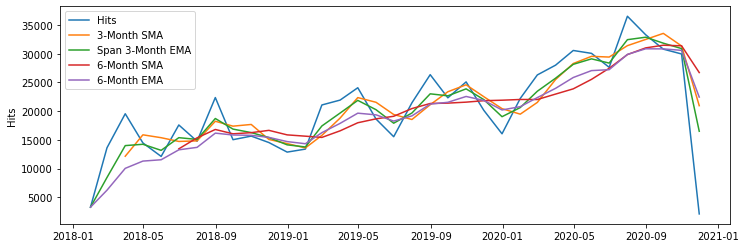

In [60]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(hitspermonth.index, 
        hitspermonth,
        label='Hits')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '3-Month SMA')
ax.plot(short_rolling.index, 
        ema_short, 
        label = 'Span 3-Month EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '6-Month SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = '6-Month EMA')

ax.legend(loc='best')
ax.set_ylabel('Hits')
plt.show()

In [61]:
stdev = hitspermonth.ewm(span=span).std()
# Create boolinger bands using std * 3 method
midband = hitspermonth.ewm(span=span).mean()
ub = midband + stdev*3
lb = midband - stdev*3
midband

datetime
2018-01-31     3270.000000
2018-02-28     8617.500000
2018-03-31    12506.507960
2018-04-30    13045.041741
2018-05-31    12832.752155
2018-06-30    13763.628392
2018-07-31    13936.303265
2018-08-31    15251.950818
2018-09-30    15219.936399
2018-10-31    15277.208876
2018-11-30    15184.596001
2018-12-31    14912.899917
2019-01-31    14743.103834
2019-02-28    15416.536288
2019-03-31    16081.176691
2019-04-30    16867.864327
2019-05-31    17035.309038
2019-06-30    16897.929609
2019-07-31    17307.828466
2019-08-31    18100.572260
2019-09-30    18462.261085
2019-10-31    19018.828941
2019-11-30    19112.206654
2019-12-31    18865.028092
2020-01-31    19131.761746
2020-02-29    19694.422650
2020-03-31    20337.610450
2020-04-30    21118.730135
2020-05-31    21793.974881
2020-06-30    22229.746833
2020-07-31    23286.704916
2020-08-31    24020.466564
2020-09-30    24512.744397
2020-10-31    24905.215617
2020-11-30    23275.494609
Freq: M, dtype: float64

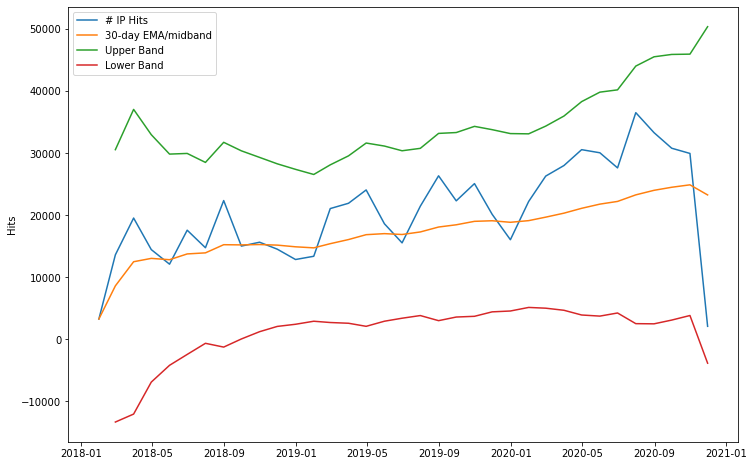

In [62]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(hitspermonth.index, 
        hitspermonth,
        label='# IP Hits')

ax.plot(hitspermonth.index, 
        midband, 
        label = '30-day EMA/midband')
ax.plot(hitspermonth.index, 
        ub, 
        label = 'Upper Band')
ax.plot(hitspermonth.index, 
        lb, 
        label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Hits')
plt.show()

In [63]:
hitspermonth = pd.concat([hitspermonth, midband, ub, lb], axis=1)
hitspermonth.columns = ['ip_hits', 'midband', 'ub', 'lb']
hitspermonth.tail()

,ip_hits,midband,ub,lb
datetime,,,,
2020-07-31,36540,23286.704916,44050.389892,2523.019939
2020-08-31,33314,24020.466564,45546.495775,2494.437353
2020-09-30,30806,24512.744397,45926.658134,3098.830660
2020-10-31,29966,24905.215617,45974.842793,3835.588442
2020-11-30,2092,23275.494609,50401.095212,-3850.105994


In [64]:
# Creating a percent b column
hitspermonth['pct_b'] = (hitspermonth['ip_hits'] - hitspermonth['lb'])/(hitspermonth['ub'] - hitspermonth['lb'])
# Sorting by values > 1
hitspermonth[hitspermonth['pct_b']>.75]

,ip_hits,midband,ub,lb,pct_b
datetime,,,,,
2019-08-31,26358,18100.572260,33195.502335,3005.642185,0.773517
2020-04-30,30574,21118.730135,38319.466078,3917.994192,0.774851
2020-07-31,36540,23286.704916,44050.389892,2523.019939,0.819146


# Bonus

In [65]:
cohort = data[['date', 'cohort_id', 'user_id']].groupby(['cohort_id', 'user_id']).min().reset_index()
cohort.groupby(['cohort_id', 'user_id']).agg(['min', 'max'])

date            
                          min         max
cohort_id user_id                        
1.0       11       2018-01-26  2018-01-26
          60       2018-01-29  2018-01-29
          64       2018-01-29  2018-01-29
          95       2018-02-10  2018-02-10
          141      2018-03-14  2018-03-14
...                       ...         ...
62.0      772      2020-09-21  2020-09-21
          773      2020-09-21  2020-09-21
          774      2020-09-21  2020-09-21
          775      2020-09-23  2020-09-23
          776      2020-09-24  2020-09-24

[748 rows x 2 columns]